# ECE176 Final Project

In [1]:
# Import Packages
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle
import json
import seaborn as sns

## Dataset

In [2]:
import torch
print(torch.__version__)          # Should show a version with CUDA (not CPU)
print(torch.cuda.is_available())  # Should return True
print(torch.version.cuda)         # Should match your CUDA version

if torch.cuda.is_available():
    device = torch.device("cuda")
    gpu_name = torch.cuda.get_device_name(device)
    gpu_capability = torch.cuda.get_device_capability(device)
    total_memory = torch.cuda.get_device_properties(device).total_memory / 1e9  # Convert to GB

    print(f"GPU Name: {gpu_name}")
    print(f"Compute Capability: {gpu_capability}")
    print(f"Total Memory: {total_memory:.2f} GB")
else:
    print("CUDA device not available.")


2.6.0+cu118
True
11.8
GPU Name: NVIDIA GeForce RTX 3080 Laptop GPU
Compute Capability: (8, 6)
Total Memory: 17.18 GB


In [4]:
import os

# Directories for the splits
train_dir = "datasets/tokenized/train"
val_dir = "datasets/tokenized/val"
test_dir = "datasets/tokenized/test"

# Get file lists for each split
train_files = os.listdir(train_dir)
val_files = os.listdir(val_dir)
test_files = os.listdir(test_dir)

# Convert to sets for uniqueness testing
train_set = set(train_files)
val_set = set(val_files)
test_set = set(test_files)

# Print the number of files in each split
print(f"Train set contains: {len(train_files)} files")
print(f"Validation set contains: {len(val_files)} files")
print(f"Test set contains: {len(test_files)} files")

# Check for uniqueness within each split
assert len(train_files) == len(train_set), "There are duplicate files in the train split!"
assert len(val_files) == len(val_set), "There are duplicate files in the validation split!"
assert len(test_files) == len(test_set), "There are duplicate files in the test split!"

# Check for uniqueness across splits (no file should appear in more than one split)
intersection_train_val = train_set.intersection(val_set)
intersection_train_test = train_set.intersection(test_set)
intersection_val_test = val_set.intersection(test_set)

print("\nIntersections:")
print(f"Train ∩ Validation: {intersection_train_val}")
print(f"Train ∩ Test: {intersection_train_test}")
print(f"Validation ∩ Test: {intersection_val_test}")

assert not intersection_train_val, "Some files are present in both train and validation splits!"
assert not intersection_train_test, "Some files are present in both train and test splits!"
assert not intersection_val_test, "Some files are present in both validation and test splits!"

print("\n✅ All splits are correct and all files are unique!")


Train set contains: 39905 files
Validation set contains: 4977 files
Test set contains: 5019 files

Intersections:
Train ∩ Validation: set()
Train ∩ Test: set()
Validation ∩ Test: set()

✅ All splits are correct and all files are unique!


In [5]:
# Paths
TRAIN_DATA_PATH = "datasets/tokenized/train"
VOCAB_PATH = "datasets/vocab/basic_vocab.json"

# Load vocabulary
with open(VOCAB_PATH, "r") as f:
    vocab = json.load(f)

# Reverse vocab (ID -> Token)
id_to_token = {v: k for k, v in vocab.items()}

# Load tokenized sequences
def load_all_sequences(data_path, max_files=1000):
    """Loads all tokenized sequences from the specified dataset path."""
    sequences = []
    files = sorted(os.listdir(data_path))[:max_files]  # Limit for performance
    for file in files:
        if file.endswith(".pkl"):
            with open(os.path.join(data_path, file), "rb") as f:
                seq = pickle.load(f)
                if len(seq) == 0:
                    print(file)
                sequences.append(seq)
    return sequences

train_sequences = load_all_sequences(TRAIN_DATA_PATH)
print(f"Loaded {len(train_sequences)} tokenized sequences from {TRAIN_DATA_PATH}")

Loaded 1000 tokenized sequences from datasets/tokenized/train


In [6]:
def ids_to_tokens(vocab, id_sequence):
    # Reverse the vocab (ID -> Token)
    id_to_token = {v: k for k, v in vocab.items()}

    # Convert token IDs back to tokens
    token_sequence = [id_to_token.get(token_id, "<UNK>") for token_id in id_sequence]

    return token_sequence

id_sequence = train_sequences[1]  # Example sequence of token IDs
tokens = ids_to_tokens(vocab, id_sequence)

print(len(tokens))
print("Decoded Tokens:", tokens)


6481
Decoded Tokens: ['NOTE_ON_64', 'VELOCITY_15', 'TIME_SHIFT_10ms', 'TIME_SHIFT_10ms', 'TIME_SHIFT_10ms', 'TIME_SHIFT_10ms', 'TIME_SHIFT_10ms', 'NOTE_ON_45', 'VELOCITY_16', 'TIME_SHIFT_10ms', 'TIME_SHIFT_10ms', 'NOTE_ON_72', 'VELOCITY_20', 'TIME_SHIFT_30ms', 'TIME_SHIFT_10ms', 'NOTE_OFF_64', 'TIME_SHIFT_260ms', 'TIME_SHIFT_10ms', 'NOTE_ON_52', 'VELOCITY_19', 'TIME_SHIFT_270ms', 'TIME_SHIFT_10ms', 'NOTE_OFF_45', 'TIME_SHIFT_50ms', 'TIME_SHIFT_10ms', 'NOTE_ON_57', 'VELOCITY_16', 'TIME_SHIFT_10ms', 'TIME_SHIFT_10ms', 'NOTE_OFF_52', 'TIME_SHIFT_40ms', 'TIME_SHIFT_10ms', 'NOTE_OFF_57', 'TIME_SHIFT_250ms', 'TIME_SHIFT_10ms', 'NOTE_ON_59', 'VELOCITY_18', 'TIME_SHIFT_30ms', 'TIME_SHIFT_10ms', 'NOTE_OFF_59', 'TIME_SHIFT_300ms', 'TIME_SHIFT_10ms', 'NOTE_ON_71', 'VELOCITY_24', 'TIME_SHIFT_10ms', 'TIME_SHIFT_10ms', 'NOTE_ON_43', 'VELOCITY_18', 'TIME_SHIFT_10ms', 'TIME_SHIFT_10ms', 'NOTE_OFF_72', 'TIME_SHIFT_10ms', 'TIME_SHIFT_10ms', 'TIME_SHIFT_70ms', 'TIME_SHIFT_10ms', 'TIME_SHIFT_10ms', 'TIME_

Min Length: 11
Max Length: 92429
Mean Length: 21859.72
Median Length: 20925.0
Number of zero lenght sequences: 0


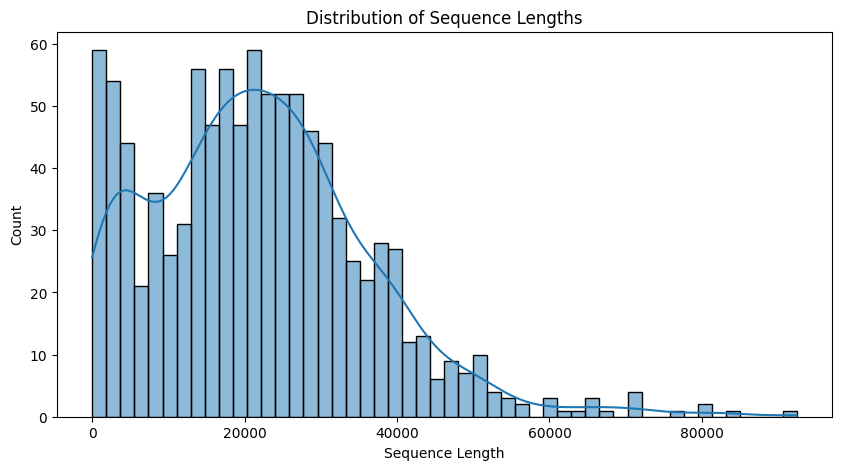

In [7]:
seq_lengths = []
num_zero_len = 0
for seq in train_sequences:
    seq_lengths.append(len(seq))
    if len(seq) == 0:
        num_zero_len += 1

# Statistics
print(f"Min Length: {np.min(seq_lengths)}")
print(f"Max Length: {np.max(seq_lengths)}")
print(f"Mean Length: {np.mean(seq_lengths):.2f}")
print(f"Median Length: {np.median(seq_lengths)}")
print(f"Number of zero lenght sequences: {num_zero_len}")

# Histogram of sequence lengths
plt.figure(figsize=(10, 5))
sns.histplot(seq_lengths, bins=50, kde=True)
plt.xlabel("Sequence Length")
plt.ylabel("Count")
plt.title("Distribution of Sequence Lengths")
plt.show()


Top 20 Most Frequent Tokens:
TIME_SHIFT_10ms: 5913281
TIME_SHIFT_20ms: 458116
VELOCITY_25: 387625
NOTE_OFF_42: 376172
NOTE_ON_42: 375764
TIME_SHIFT_30ms: 357071
VELOCITY_23: 302502
VELOCITY_32: 298167
VELOCITY_20: 273551
VELOCITY_24: 255138
VELOCITY_22: 238650
VELOCITY_21: 238386
VELOCITY_18: 223238
VELOCITY_28: 222321
VELOCITY_26: 216105
TIME_SHIFT_50ms: 214360
TIME_SHIFT_40ms: 203344
VELOCITY_19: 203279
VELOCITY_16: 197565
VELOCITY_27: 186444


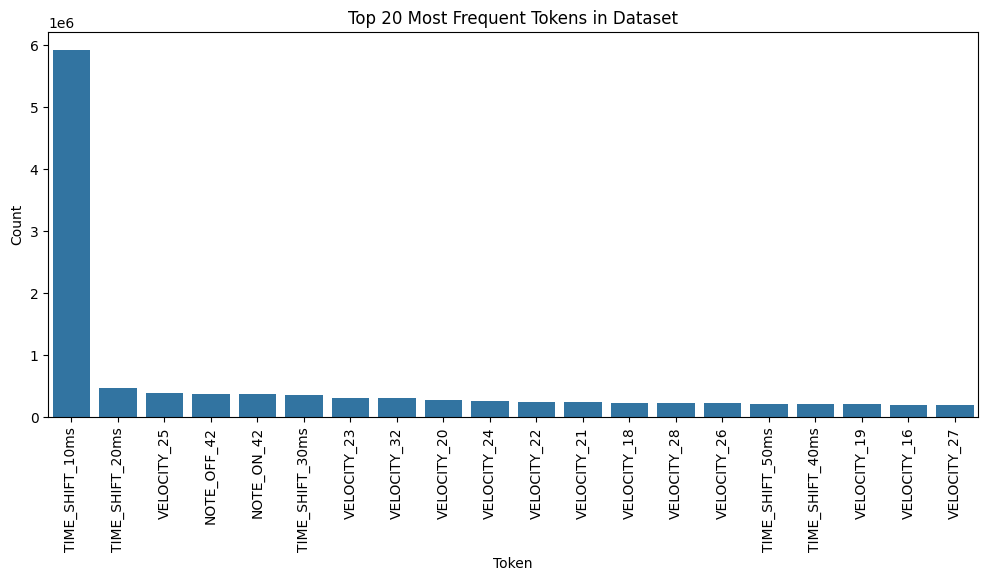

In [8]:
from collections import Counter

# Flatten sequences into a single list of token IDs
all_tokens = [token for seq in train_sequences for token in seq]

# Count token occurrences
token_counts = Counter(all_tokens)

# Convert to token names
token_names = {id_to_token[k]: v for k, v in token_counts.items()}
sorted_tokens = sorted(token_names.items(), key=lambda x: x[1], reverse=True)

# Display top 20 tokens
print("Top 20 Most Frequent Tokens:")
for token, count in sorted_tokens[:20]:
    print(f"{token}: {count}")

# Bar plot of most common tokens
plt.figure(figsize=(12, 5))
sns.barplot(x=[t[0] for t in sorted_tokens[:20]], y=[t[1] for t in sorted_tokens[:20]])
plt.xticks(rotation=90)
plt.xlabel("Token")
plt.ylabel("Count")
plt.title("Top 20 Most Frequent Tokens in Dataset")
plt.show()


Top 15 Most Frequent TIME_SHIFT Tokens:
TIME_SHIFT_10ms: 6024382
TIME_SHIFT_20ms: 485016
TIME_SHIFT_30ms: 365672
TIME_SHIFT_40ms: 215991
TIME_SHIFT_50ms: 211109
TIME_SHIFT_60ms: 170282
TIME_SHIFT_80ms: 112162
TIME_SHIFT_70ms: 110156
TIME_SHIFT_100ms: 88466
TIME_SHIFT_90ms: 76732
TIME_SHIFT_110ms: 65752
TIME_SHIFT_120ms: 56745
TIME_SHIFT_130ms: 44308
TIME_SHIFT_150ms: 37247
TIME_SHIFT_140ms: 33581


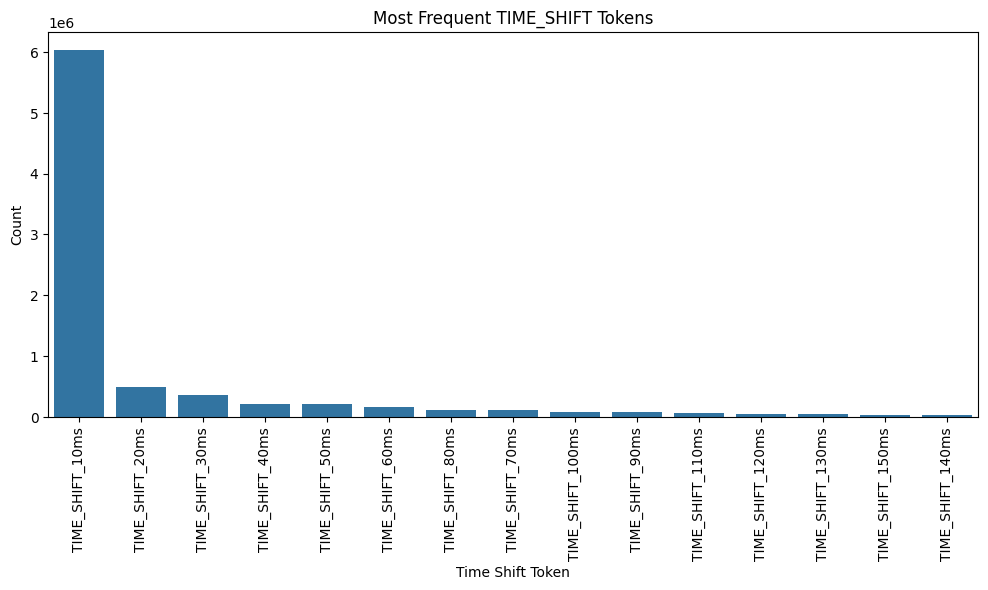

In [10]:
# Extract all TIME_SHIFT tokens
time_shift_tokens = [id_to_token[token] for token in all_tokens if "TIME_SHIFT" in id_to_token[token]]

# Count occurrences of each TIME_SHIFT value
time_shift_counts = Counter(time_shift_tokens)
sorted_shifts = sorted(time_shift_counts.items(), key=lambda x: x[1], reverse=True)

# Display top 15 time shifts
print("Top 15 Most Frequent TIME_SHIFT Tokens:")
for shift, count in sorted_shifts[:15]:
    print(f"{shift}: {count}")

# Plot distribution of TIME_SHIFT tokens
plt.figure(figsize=(12, 5))
sns.barplot(x=[t[0] for t in sorted_shifts[:15]], y=[t[1] for t in sorted_shifts[:15]])
plt.xticks(rotation=90)
plt.xlabel("Time Shift Token")
plt.ylabel("Count")
plt.title("Most Frequent TIME_SHIFT Tokens")
plt.show()


Top 10 Most Frequent VELOCITY Tokens:
NOTE_OFF_42: 376172
NOTE_OFF_62: 184736
NOTE_OFF_64: 180059
NOTE_OFF_69: 167251
NOTE_OFF_36: 158561
NOTE_OFF_60: 155111
NOTE_OFF_54: 151878
NOTE_OFF_67: 147327
NOTE_OFF_35: 135387
NOTE_OFF_57: 133416


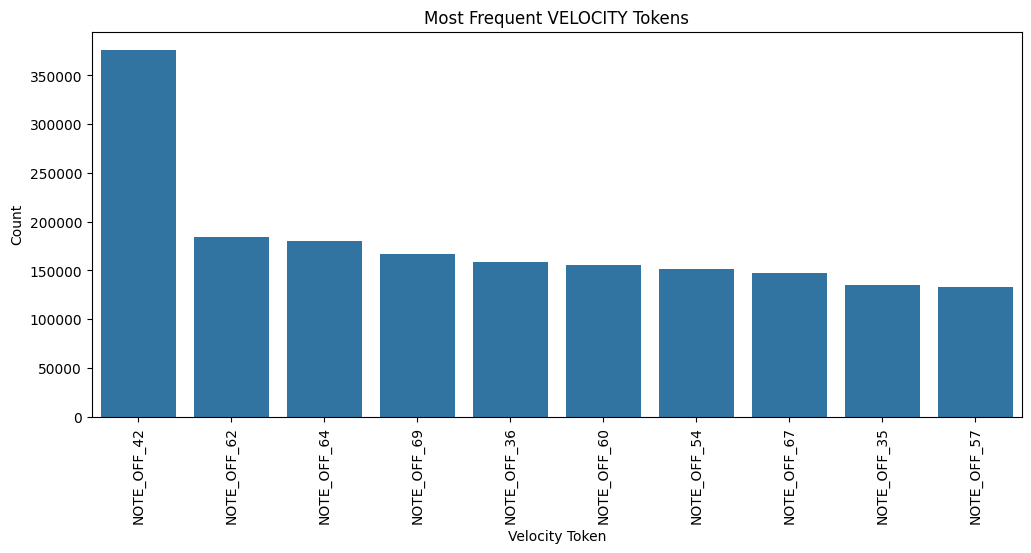

In [9]:
# Extract all VELOCITY tokens
velocity_tokens = [id_to_token[token] for token in all_tokens if "NOTE_OFF" in id_to_token[token]]

# Count occurrences
velocity_counts = Counter(velocity_tokens)
sorted_velocities = sorted(velocity_counts.items(), key=lambda x: x[1], reverse=True)

# Display top 10 velocities
print("Top 10 Most Frequent VELOCITY Tokens:")
for vel, count in sorted_velocities[:10]:
    print(f"{vel}: {count}")

# Plot velocity distribution
plt.figure(figsize=(12, 5))
sns.barplot(x=[t[0] for t in sorted_velocities[:10]], y=[t[1] for t in sorted_velocities[:10]])
plt.xticks(rotation=90)
plt.xlabel("Velocity Token")
plt.ylabel("Count")
plt.title("Most Frequent VELOCITY Tokens")
plt.show()


🔹 Average initial TIME_SHIFT tokens: 0.00
🔹 Average ending TIME_SHIFT tokens: 0.00


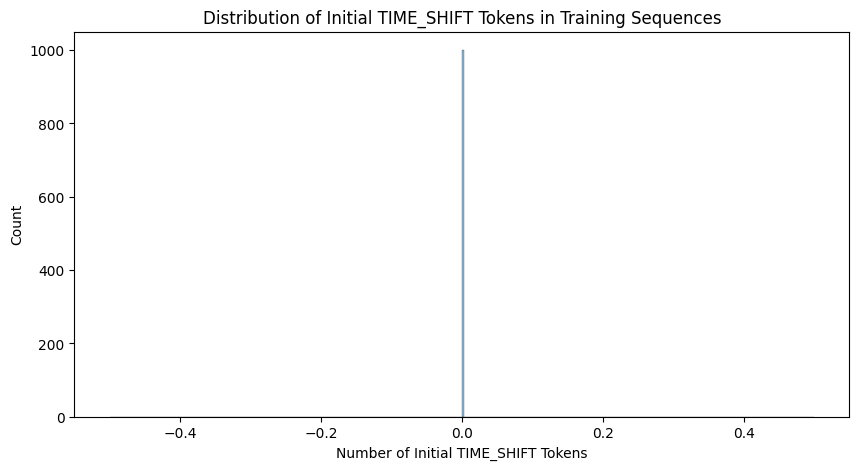

In [10]:
def count_initial_time_shifts(sequences, id_to_token):
    time_shift_counts = []
    for seq in sequences:
        count = 0
        for token_id in seq:
            token = id_to_token.get(token_id, "")
            if token.startswith("TIME_SHIFT_"):
                count += 1
            else:
                break  # Stop counting once a non-time-shift token is encountered
        time_shift_counts.append(count)
    return time_shift_counts

def count_ending_time_shifts(sequences, id_to_token):
    time_shift_counts = []
    for seq in sequences:
        count = 0
        for token_id in reversed(seq):  # Iterate from the end
            token = id_to_token.get(token_id, "")
            if token.startswith("TIME_SHIFT_"):
                count += 1
            else:
                break  # Stop counting once a non-time-shift token is encountered
        time_shift_counts.append(count)
    return time_shift_counts

initial_time_shifts = count_initial_time_shifts(train_sequences, id_to_token)
print(f"🔹 Average initial TIME_SHIFT tokens: {np.mean(initial_time_shifts):.2f}")

ending_time_shifts = count_ending_time_shifts(train_sequences, id_to_token)
print(f"🔹 Average ending TIME_SHIFT tokens: {np.mean(ending_time_shifts):.2f}")


plt.figure(figsize=(10, 5))
sns.histplot(initial_time_shifts, bins=300, kde=True)
plt.xlabel("Number of Initial TIME_SHIFT Tokens")
plt.ylabel("Count")
plt.title("Distribution of Initial TIME_SHIFT Tokens in Training Sequences")
plt.show()


In [11]:
import numpy as np

# Function to compute the proportion of initial TIME_SHIFT tokens per sequence
def compute_time_shift_proportions(sequences, id_to_token):
    proportions = []
    
    for seq in sequences:
        total_length = len(seq)
        time_shift_count = 0

        # Count initial TIME_SHIFT tokens
        for token_id in seq:
            token = id_to_token.get(token_id, "")
            if token.startswith("TIME_SHIFT_"):
                time_shift_count += 1
            else:
                break  # Stop once a non-TIME_SHIFT token is encountered

        # Compute proportion of silence in the song
        proportion = time_shift_count / total_length if total_length > 0 else 0
        proportions.append(proportion)

    return proportions

# Compute proportions for training data
time_shift_proportions = compute_time_shift_proportions(train_sequences, id_to_token)

# Display basic statistics
print(f"🔹 Average Silence Proportion: {np.mean(time_shift_proportions):.2%}")
print(f"🔹 Median Silence Proportion: {np.median(time_shift_proportions):.2%}")
print(f"🔹 Max Silence Proportion: {np.max(time_shift_proportions):.2%}")
print(f"🔹 Min Silence Proportion: {np.min(time_shift_proportions):.2%}")

🔹 Average Silence Proportion: 0.00%
🔹 Median Silence Proportion: 0.00%
🔹 Max Silence Proportion: 0.00%
🔹 Min Silence Proportion: 0.00%


In [12]:
silent_endings = sum(1 for count in ending_time_shifts if count > 30)  # Threshold for excessive silence
total_sequences = len(ending_time_shifts)

print(f"🔹 Sequences with >50 Ending TIME_SHIFT Tokens: {silent_endings}/{total_sequences} ({silent_endings / total_sequences * 100:.2f}%)")


🔹 Sequences with >50 Ending TIME_SHIFT Tokens: 0/1000 (0.00%)
